In [1]:
from __future__ import annotations

import relaxed
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any
from functools import partial
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

Array = jnp.ndarray

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

In [13]:
def generate_data(
    rng: int = 0,
    num_points: int = 10000,
    sig_mean: tuple[float, float] = (-1, 1),
    bup_mean: tuple[float, float] = (2.5, 2),
    bdown_mean: tuple[float, float] = (-2.5, -1.5),
    b_mean: tuple[float, float] = (1, -1),
) -> tuple[Array, Array, Array, Array]:
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down

Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. we';;Since our likelihood modelling stage will later t

In [ ]:
def hists_from_pars(
    pars: dict[str, Array],
    data: dict[str, Array],
    nn: Callable,
    bandwidth: float,
    bins: Array | None = None,
    scale_factors: dict[str, float] | None = None,
    overall_scale: float = 1.0,
) -> dict[str, Array]:
    """Function that takes in data + analysis config parameters, and constructs yields."""
    # apply the neural network to each data sample, and keep track of the sample names in a dict
    nn_output = {k: nn(pars["nn_pars"], data[k]).ravel() for k in data}

    # The next two lines allow you to also optimise your binning:
    bins = jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    # define our histogram-maker with some hyperparameters (bandwidth, binning)
    make_hist = partial(relaxed.hist, bandwidth=bandwidth, bins=bins_new)

    # every histogram is scaled to the number of points from that data source in the batch
    # so we have more control over the scaling of sig/bkg for realism
    scale_factors = scale_factors or {k: 1.0 for k in nn_output}
    hists = {
        k: make_hist(nn_output[k]) * scale_factors[k] * overall_scale / len(v)
        + 1e-3  # add a floor so no zeros in any bin!
        for k, v in nn_output.items()
    }
    return hists


# specific to use case
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None},
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],
                                    "lo_data": hists["bkg_down"],
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)


def poi_uncert(model: pyhf.Model) -> float:
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(1.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.cramer_rao_uncert(model, hypothesis_pars, observed_hist)[
        model.config.poi_index
    ]


def trace(model: pyhf.Model) -> float:
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(1.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    uncert = relaxed.cramer_rao_uncert(model, hypothesis_pars, observed_hist)
    np = [
        uncert[model.config.par_slice(k)]
        for k in model.config.par_order
        if model.config.param_set(k).constrained
    ]
    return uncert[model.config.poi_index] + 0.1 * (1 - jnp.array(np).ravel())[0] ** 2


def discovery_significance(model: pyhf.Model, fit_lr: float) -> float:
    test_stat = "q0"
    test_poi = 0.0
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(1.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.infer.hypotest(
        test_poi=test_poi,
        data=observed_hist,
        model=model,
        test_stat=test_stat,
        expected_pars=hypothesis_pars,
        lr=fit_lr,
    )


def cls_value(model: pyhf.Model, fit_lr: float) -> float:
    test_stat = "q"
    test_poi = 1.0
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return relaxed.infer.hypotest(
        test_poi=test_poi,
        data=observed_hist,
        model=model,
        test_stat=test_stat,
        expected_pars=hypothesis_pars,
        lr=fit_lr,
    )


def generalised_variance(model: pyhf.Model) -> float:
    hypothesis_pars = (
        jnp.asarray(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
    )
    observed_hist = jnp.asarray(model.expected_data(hypothesis_pars))
    return 1 / jnp.linalg.det(
        relaxed.fisher_info(model, hypothesis_pars, observed_hist)
    )


def loss_from_model(
    model: pyhf.Model,
    loss: str | Callable[[dict[str, Any]], float] = "neos",
    fit_lr: float = 1e-3,
) -> float:
    if isinstance(loss, Callable):
        # everything
        return 0
    # loss specific
    if loss.lower() == "discovery":
        return discovery_significance(model, fit_lr)
    elif loss.lower() in ["neos", "cls"]:
        return cls_value(model, fit_lr)
    elif loss.lower() in ["inferno", "poi_uncert", "mu_uncert"]:
        return poi_uncert(model)
    elif loss.lower() in [
        "general_variance",
        "generalised_variance",
        "generalized_variance",
    ]:
        return generalised_variance(model)
    elif loss.lower() in ["trace"]:
        return trace(model)
    else:
        raise ValueError(f"loss function {loss} not recognised")


def sigmoid_cross_entropy_with_logits(preds, labels):
    return jnp.mean(
        jnp.maximum(preds, 0) - preds * labels + jnp.log1p(jnp.exp(-jnp.abs(preds)))
    )


def bce_loss(data, nn, pars):
    preds = {k: nn(pars["nn_pars"], data[k]).ravel() for k in data}
    bkg = jnp.concatenate([preds[k] for k in preds if "sig" not in k])
    sig = preds["sig"]
    labels = jnp.concatenate([jnp.ones_like(sig), jnp.zeros_like(bkg)])
    return sigmoid_cross_entropy_with_logits(
        jnp.concatenate(list(preds.values())).ravel(), labels
    ).mean()


def pipeline(pars, data, bins, nn, loss, bandwidth, keys, scale_factors):
    data_dct = {k: v for k, v in zip(keys, data)}
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return bce_loss(data=data_dct, pars=pars, nn=nn)
    hists = hists_from_pars(
        pars=pars,
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,
        bins=bins,
        scale_factors=scale_factors,
    )
    model = model_from_hists(hists)
    return loss_from_model(model, loss=loss)

In [2]:
from jax.experimental import stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 3000
data = generate_data(rng=rng_state, num_points=10000)
split = train_test_split(*data, random_state=rng_state)
train, test = split[::2], split[1::2]

num_train = train[0].shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

# batching mechanism
def data_stream():
    rng = npr.RandomState(rng_state)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield [points[batch_idx] for points in train]


batch_iterator = data_stream()

In [5]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
bins = jnp.linspace(0, 1, 5)
lr = 1e-3
num_steps = 25
objective = "neos"

data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
loss = partial(
    pipeline,
    nn=nn,
    keys=data_types,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
)

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)
if include_bins:
    init_pars["bins"] = bins[
        1:-1
    ]  # don't want to float endpoints [will account for kde spill]
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)
params = init_pars
best_params = init_pars
best_sig = 10.0
metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}
for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [", *[f"{f:.3g}" for f in params["bins"]], "]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    if metrics["discovery"][-1] < best_sig:
        best_params = params
        best_sig = metrics["discovery"][-1]
    print()

step 0: loss=neos
update took 2.43s
bin edges: [ 0.251 0.499 0.749 ]
cls=0.2172
discovery=0.2453
poi_uncert=1.388

step 1: loss=neos
update took 2.767s
bin edges: [ 0.252 0.498 0.748 ]
cls=0.1385
discovery=0.1846
poi_uncert=0.9084

step 2: loss=neos
update took 2.91s
bin edges: [ 0.253 0.497 0.747 ]
cls=0.1278
discovery=0.2066
poi_uncert=0.9593

step 3: loss=neos
update took 2.311s
bin edges: [ 0.253 0.497 0.747 ]
cls=0.1236
discovery=0.1786
poi_uncert=0.8505

step 4: loss=neos
update took 2.973s
bin edges: [ 0.254 0.496 0.746 ]
cls=0.1217
discovery=0.1721
poi_uncert=0.8402

step 5: loss=neos
update took 2.674s
bin edges: [ 0.254 0.495 0.745 ]
cls=0.121
discovery=0.1788
poi_uncert=0.8952

step 6: loss=neos
update took 2.4s
bin edges: [ 0.255 0.495 0.744 ]
cls=0.1174
discovery=0.1751
poi_uncert=0.9224

step 7: loss=neos
update took 3.156s
bin edges: [ 0.255 0.494 0.743 ]
cls=0.1188
discovery=0.1593
poi_uncert=0.9065

step 8: loss=neos
update took 2.909s
bin edges: [ 0.255 0.494 0.742 ]


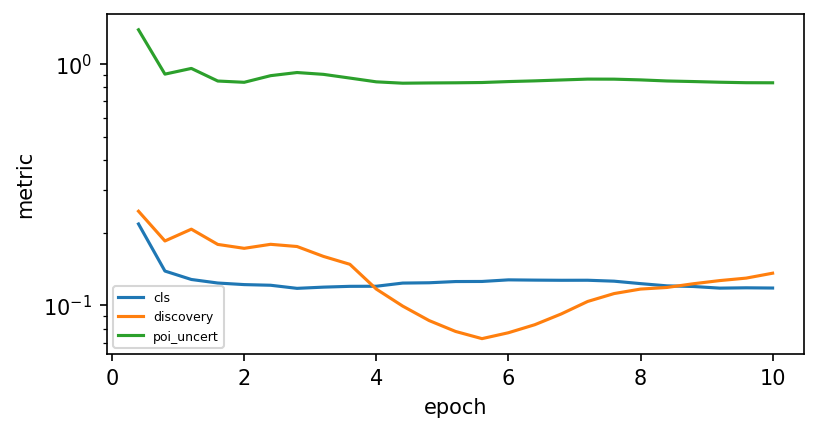

In [6]:
import matplotlib.pyplot as plt

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / num_train
for k, v in metrics.items():
    if k != "generalised_variance":
        plt.plot(epoch_grid, v, label=k)
plt.yscale("log")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("metric")
plt.savefig("float.png")

In [7]:
yields = hists_from_pars(
    best_params,
    {k: v for k, v in zip(data_types, test)},
    nn,
    bandwidth=1e-8,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
)

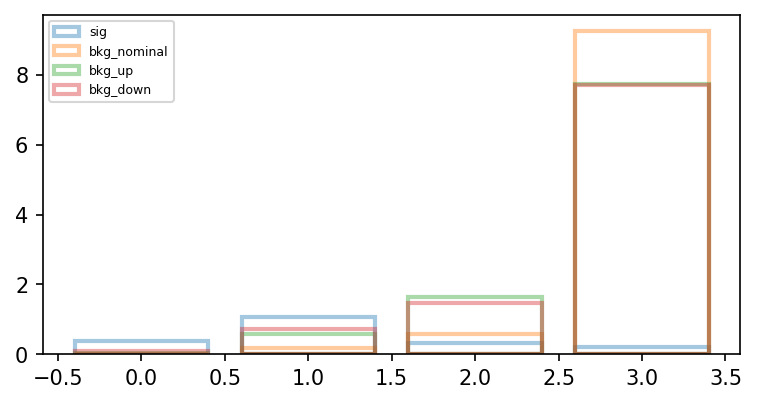

In [8]:
for c, (l, a) in zip(
    ["C0", "C1", "C2", "C3"], zip(yields, jnp.array(list(yields.values())))
):
    plt.bar(range(len(a)), a, label=l, alpha=0.4, fill=None, edgecolor=c, linewidth=2)
plt.legend()

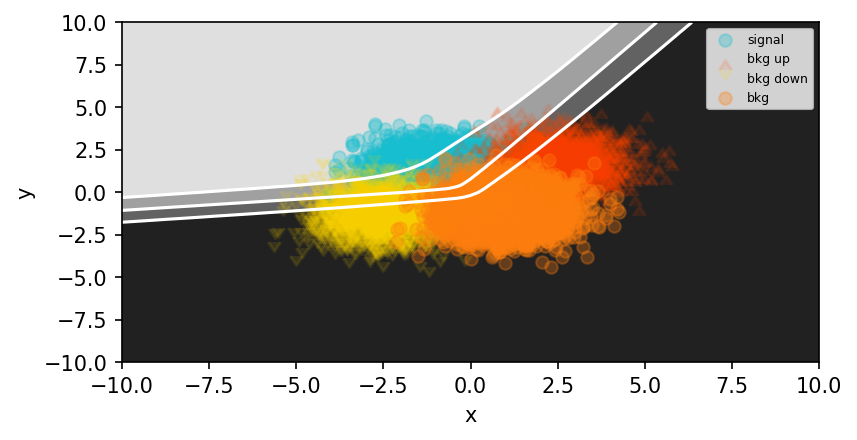

In [11]:
def plot_data_space(
    ax: Any,
    params: dict[str, Any],
    data: Array,
    nn: Callable,
    bins: Array | None = None,
) -> None:
    network = params["nn_pars"]
    bins = params["bins"] if "bins" in params else bins
    g = jnp.mgrid[-10:10:101j, -10:10:101j]
    levels = [0, *bins, 1]
    ax.contourf(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = data
    # should definitely not have to repeat this every time lmao
    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0],
        bkg_up[:, 1],
        alpha=0.1,
        c="orangered",
        marker=6,
        label="bkg up",
    )
    ax.scatter(
        bkg_down[:, 0],
        bkg_down[:, 1],
        alpha=0.1,
        c="gold",
        marker=7,
        label="bkg down",
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()


plot_data_space(ax, best_params, data=test, nn=nn)